# Курсовая работа

## Применение разложения Холецкого для решения СЛАУ. Пример использования в методе наименьших квадратов.

## Цель

Исследовать методы решения СЛАУ с симметричной положительно определенной матрицей. Изучить их применимость в методе наименьших квадратов для разных типов задач, решаемых этим методом.

In [2]:
import numpy as np 
import scipy.linalg as sla
import matplotlib.pyplot as plt
from time import time
import math

## Разложение Холецкого

Если матрица $A$ - симметричная положительно определенная, то она может быть представлена в виде: 

$$A = LL^T$$, 

где $L$ - нижнетреугольная с положительными элементами на диагонали, а $L^T$ - верхнетреугольная.

Алгоритм вычисления матрицы $L$ состоит из $n$ однотипных шагов;
на $j$-м шаге, где $j = 0, ... n-1$, вычисляется $j$-й столбец данной матрицы. В свою очередь, шаг включает два этапа: 

Этап 1: вычислить диагональный элемент $l_{jj}$ по формуле

$$l_{jj} = \sqrt{a_{jj}- \sum_{k=0}^{k<j}{l_{ik}l_{jk}}}$$

Этап 2: при $i = j+1,...,n-1$ вычислить:

$$l_{ij} = (a_{ij}- \sum_{k=0}^{k<j}{l_{ik}l_{jk}})/l_{jj}$$

Число арифметических операций, требуемых изложенным алгоритмом для получения разложения: $1/3 n^3 + O(n^2)$

Реализация в Python: `scipy.linalg.cholesky`

## Решение СЛАУ

Теперь рассмотрим систему линейных алгебраических уравнений

$$ A\vec{x} = \vec{b} \;\;\; (*)$$

### Разложение Холецкого

После того, как разложение для матрицы $A$ получено:

$$LL^T\vec{x} = \vec{b},$$

решение системы $(*)$ сводится с к решениию двух СЛАУ с треугольными матрицами: 

$$L\vec{y} = \vec{b}$$
$$y_j = (b_j - \sum_{k=0}^{k<j}{l_{jk}y_k})/l_{jj}, \;\; j = 0,..,n-1$$

$$L^T\vec{x} = \vec{y}$$
$$x_j = (y_j - \sum_{k=j+1}^{k<n}{l_{kj}x_k})/l_{jj}, \;\; j = n-1,..,0$$

Для каждой из систем вычисления требуют $n^2$ арифметических операций.

В Python: `scipy.linalg.solve_triangular`

Таким образом при таком способобе решения требуется $O(n^3)$ подготовительных операций и $O(n^2)$ операций для непосредственного решения системы. 

Так же реализованы две функции, предназначенные непосредственно для решения СЛАУ через разложение Холецкого: `scipy.linalg.cho_factor` и `scipy.linalg.cho_solve`. Первая так же вычисляет разложение, однако возвращаемая матрица может содержать случайные значения вне верхнего/нижнего треугольника. Вторая решает СЛАУ указанным выше способом, используя результат первой функции. 

### Другие способы:

* Стандартная функция `scipy` для решения СЛАУ: `scipy.linalg.solve`. В самом общем случае использует LU-разложение матрицы (LAPAK ?GESV).

$$A = LU,$$
где $L$ - нижнетреугольная, а $U$ - верхнетреугольная.

Алгоритм LU-разложения требует $n^3/3 + O(n^2)$ аддитивных и столько же мультипоикативных опреаций. Решение СЛАУ так же разбивается на последовательное решение двух систем с треугольными матрицами - по $O(n^2)$ опреций для каждой. Но, так как именно этот метод не позволяет "запомнить" вычисленное разложение, для решения нескольких систем с одной матрицей этот способ будет давать $O(n^3)$ для каждой из систем. 

* "Наивное" обращение матрицы: 

$$\vec{x} = A^{-1}\vec{b}$$

Реализуется с помощью `scipy.linalg.inv`. Использует LAPACK GETRI, GETRF, которые (вроде бы) тоже используют LU-разложение.

Таким образом, имеем четыре способа решить СЛАУ с симметричной положительно определенной матрицей: 

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

## Сравнение методов

Определю четыре способа решения СЛАУ. Добавилю возможность дать на вход `cholesky_solve` и `cho_scipy_solve` разложение матрицы, чтобы не делать это каждый раз заново, если мы решаем системы с одной A но 10000 разных правых частей. 

In [4]:
def naive_solve(A, b):
    return sla.inv(A).dot(b)

def standart_solve(A, b):
    return sla.solve(A, b)

def cholesky_solve(A, b, L=None):
    if L is None:
        L = sla.cholesky(A, lower=True)
    y = sla.solve_triangular(L, b, lower=True)
    x = sla.solve_triangular(L.T, y)
    return x

def cho_scipy_solve(A, b, c=None, low=None):
    if c is None or low is None:
        c, low = sla.cho_factor(A)
    x = sla.cho_solve((c, low), b)
    return x

Эксперименты буду проводить со случайными матрицами. Чтобы сгенерировать их, воспользуюсь критерием положительной определенности: "Матрица $A$ положительно определена тогда и только тогда, когда существует такая невырожденная матрица $B$, что $A = BB^T$."

In [5]:
def my_sym_positive(n):
    m = np.random.randn(n,n)
    while sla.det(m) == 0:
        m = np.random.randn(n,n)
    return m.dot(m.T)

### Точность

Проведу тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов. 

In [5]:
n = 10
A = my_sym_positive(n)
x = np.ones(n)
print('correct answer: ', x.T)
b = A.dot(x).reshape(n, 1)
x_naive = naive_solve(A, b)
x_stand = standart_solve(A, b)
x_chol = cholesky_solve(A, b)
x_cho_sci = cho_scipy_solve(A, b)
print('naive: ', x_naive.T)
print('standart: ', x_stand.T)
print('cholesky: ', x_chol.T)
print('cho_scipy_solve: ', x_cho_sci.T)

correct answer:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
naive:  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
standart:  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
cholesky:  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
cho_scipy_solve:  [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


Для небольшой системы, на первый взгляд, ответы совпадают между собой и совпадают с верным ответом.

Посмотрю, что происходит с точностью вычислений при росте размера матрицы. Проведу вычисления для `n` от 10 до 100. Для каждого случая буду рассчитывать $|A\hat{x} - b|$, где $\hat{x}$ - решение.

In [15]:
err_naive = []
err_st = []
err_chol = []
err_cho = []
n_s = []

for n in range(10, 501, 10):
    n_s.append(n)
    
    A = my_sym_positive(n)
    x = np.ones(n)
    b = A.dot(x).reshape(n, 1)
    
    x_naive = naive_solve(A, b)
    x_stand = standart_solve(A, b)
    x_chol = cholesky_solve(A, b)
    x_cho_sci = cho_scipy_solve(A, b)
    
    err_naive.append(sla.norm(A.dot(x_naive) - b))
    err_st.append(sla.norm(A.dot(x_stand) - b))
    err_chol.append(sla.norm(A.dot(x_chol) - b))
    err_cho.append(sla.norm(A.dot(x_cho_sci) - b))

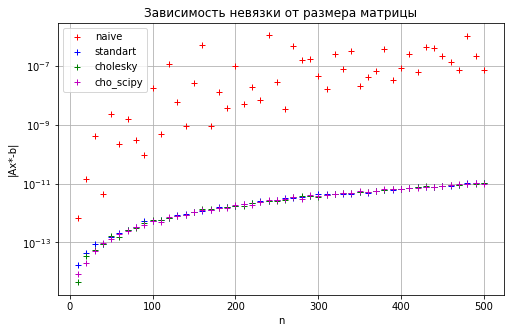

In [16]:
fig = plt.figure(figsize=(8,5))
plt.plot(n_s, err_naive, 'r+', label='naive')
plt.plot(n_s, err_st, 'b+', label='standart')
plt.plot(n_s, err_chol, 'g+', label='cholesky')
plt.plot(n_s, err_cho, 'm+', label='cho_scipy')

plt.grid()
plt.xlabel('n')
plt.ylabel('|Ax*-b|')
plt.yscale('log')

plt.title('Зависимость невязки от размера матрицы')
plt.legend()

**Результат:** Видно, что наибольшую ошибку дает обращение матрицы. Ошибка для остальных методов приблизительно одинакова и возрастает медленнее, а так же более предсказуема.  

### Исследование времени вычислений

Проведу эксперименты, чтобы выяснить, как меняется время работы методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрю системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ ($100\times100$).

**1. Рост размера A, фиксированное число правых частей**

$k$ правых частей, размер $А$ от $100$ до $1000$. $k = 10, 100, 1000$

In [ ]:
# !!!!!!!!!!!!!!!!! НЕ ПЕРЕЗАПУСКАТЬ !!!!!!!!!!!!!!!!!

k_range = [10, 100, 1000]
times = {'naive':{10:[], 100:[], 1000:[]}, 
         'standart':{10:[], 100:[], 1000:[]}, 
         'cholesky':{10:[], 100:[], 1000:[]}, 
         'cho_scipy':{10:[], 100:[], 1000:[]}
        }
n_range = [n for n in range(100,1001,100)]
for k in k_range:
    for n in n_range:
    
        A = my_sym_positive(n) #генерирую A
    
        #генерирую правые части
        b_list = []
        for i in range(k):
            x = np.random.randn(n)
            b_list.append(A.dot(x).reshape(n, 1))
        
        #naive_solve
        t0 = time()
        for b in b_list:
            naive_solve(A, b)
        t1 = time()
        times['naive'][k].append(t1-t0)
    
        #standart_solve
        t0 = time()
        for b in b_list:
            standart_solve(A, b)
        t1 = time()
        times['standart'][k].append(t1-t0)
    
        #cholesky_solve
        t0 = time()
        #разложение для каждой новой А делаю один раз
        L = sla.cholesky(A, lower=True)
        for b in b_list:
            cholesky_solve(A, b, L)
        t1 = time()
        times['cholesky'][k].append(t1-t0)
    
        #cho_scipy_solve
        t0 = time()
        #разложение для каждой новой А делаю один раз
        c, low = sla.cho_factor(A)
        for b in b_list:
            cho_scipy_solve(A, b, c, low)
        t1 = time()
        times['cho_scipy'][k].append(t1-t0)

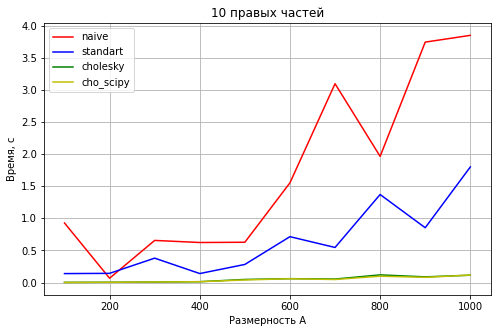

In [118]:
fig = plt.figure(figsize=(8,5))
plt.plot(n_range, times['naive'][10], 'r', label='naive')
plt.plot(n_range, times['standart'][10], 'b', label='standart')
plt.plot(n_range, times['cholesky'][10], 'g', label='cholesky')
plt.plot(n_range, times['cho_scipy'][10], 'y', label='cho_scipy')
plt.grid()
plt.xlabel('Размерность А')
plt.ylabel('Время, с')
plt.title('10 правых частей')
plt.legend()
plt.show()

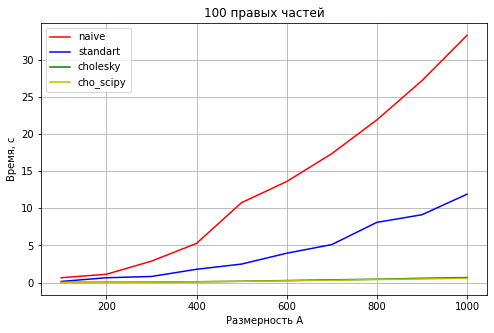

In [119]:
fig = plt.figure(figsize=(8,5))
plt.plot(n_range, times['naive'][100], 'r', label='naive')
plt.plot(n_range, times['standart'][100], 'b', label='standart')
plt.plot(n_range, times['cholesky'][100], 'g', label='cholesky')
plt.plot(n_range, times['cho_scipy'][100], 'y', label='cho_scipy')
plt.grid()
plt.xlabel('Размерность А')
plt.ylabel('Время, с')
plt.title('100 правых частей')
plt.legend()
plt.show()

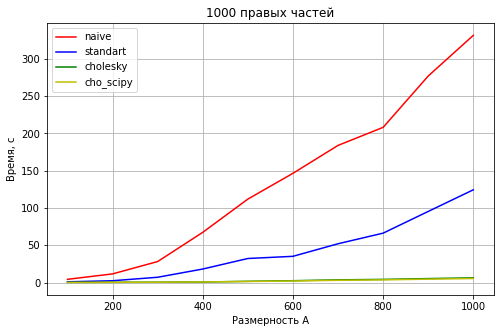

In [120]:
fig = plt.figure(figsize=(8,5))
plt.plot(n_range, times['naive'][1000], 'r', label='naive')
plt.plot(n_range, times['standart'][1000], 'b', label='standart')
plt.plot(n_range, times['cholesky'][1000], 'g', label='cholesky')
plt.plot(n_range, times['cho_scipy'][1000], 'y', label='cho_scipy')
plt.grid()
plt.xlabel('Размерность А')
plt.ylabel('Время, с')
plt.title('1000 правых частей')
plt.legend()
plt.show()

**2. A фиксированного размера, меняю число правых частей**

$А$ размера $100x100$. 

$k$ от $10$ до $10000$ с шагом $100$

In [121]:
# !!!!!!!!!!!!!!!!! НЕ ПЕРЕЗАПУСКАТЬ !!!!!!!!!!!!!!!!!

k_range = [n for n in range(10, 10001, 100)]

times_k = {'naive':[], 
         'standart':[], 
         'cholesky':[], 
         'cho_scipy':[]}

# A = 100 x 100
n = 100
A = my_sym_positive(n) #генерирую A

for k in k_range:
    
    #генерирую правые части
    b_list = []
    for i in range(k):
        x = np.random.randn(n)
        b_list.append(A.dot(x).reshape(n, 1))
        
    #naive_solve
    t0 = time()
    for b in b_list:
        naive_solve(A, b)
    t1 = time()
    times_k['naive'].append(t1-t0)
    
    #standart_solve
    t0 = time()
    for b in b_list:
        standart_solve(A, b)
    t1 = time()
    times_k['standart'].append(t1-t0)
    
    #cholesky_solve
    t0 = time()
    for b in b_list:
        cholesky_solve(A, b)
    t1 = time()
    times_k['cholesky'].append(t1-t0)
    
    #cho_scipy_solve
    t0 = time()
    for b in b_list:
        cho_scipy_solve(A, b)
    t1 = time()
    times_k['cho_scipy'].append(t1-t0)

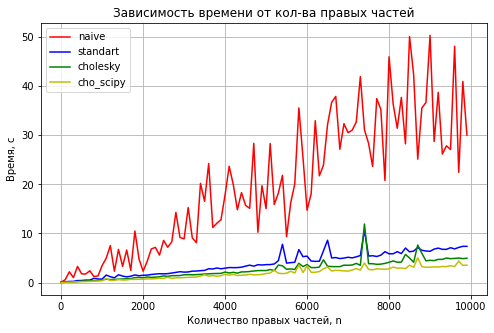

In [122]:
fig = plt.figure(figsize=(8,5))
plt.plot(k_range, times_k['naive'], 'r', label='naive')
plt.plot(k_range, times_k['standart'], 'b', label='standart')
plt.plot(k_range, times_k['cholesky'], 'g', label='cholesky')
plt.plot(k_range, times_k['cho_scipy'], 'y', label='cho_scipy')
plt.grid()
plt.xlabel('Количество правых частей, n')
plt.ylabel('Время, с')
plt.title('Зависимость времени от кол-ва правых частей')
plt.legend()
plt.show()

### Результат

По графикам видно, что "наивное" решение черз обратную матрицу дает самые плохие по скорости результаты. Самые быстрые способы решения - с использованием разложения Холецкого (как "самодельный", так и библиотечный `cho_solve`). На графиках зависимости времени от размерности матрицы $A$ `cholesky_solve` и `cho_scipy_solve` почти совпадают друг с другом. Но на графике зависимости времени от количества правых частей видно, что библиотечный (желтая линия) оказывается быстрее. "Стандарный решатель" `sla.solve` значительно лучше "наивного решения", но уступает решениям с разложением Холецкого. 

Так же можно сказать, что методы с разложением Холецкого значительно выигрывают благодаря возможность запомнить вычесленное разложение матрицы при решении большого количсетва систем с одинаковой матрице. 

На маленьких размерностях все методы дают близкие результаты. 

## Метод наименьших квадратов

Матрицы, для которых существуюет разложение Холецкого и СЛАУ с ними часто возникают при использовании метода наименьших квадратов, применяемого для регрессионного анализа и аппроксимации точечных значений некоторой функции. 

Пусть наблюдаемая случайная величина $Y$ зависит от известной или задаваемой величины $X$. Обозначим за $f(t|\vec{\theta})$ функцию, отражающую зависимость срезнего значения $Y$ от $X$ - *линию регрессии*. В случае линейной зависимости от оцениваемых параметров $\vec{\theta}$:

$$f(t|\vec{\theta}) = \theta_1g_1(t) + ... + \theta_ng_n(t)$$

Тогда в общем виде можно записать:
$$y_k = f(t|\vec{\theta}) + \epsilon_k,$$
где $\epsilon_k$ - случайные отклонения. 

В матричном виде: 
y_1
$$\vec{y} = 
\begin{pmatrix}
y_1\\.\\.\\.\\y_n
\end{pmatrix}
\;\;
\vec{\epsilon} = 
\begin{pmatrix}
\epsilon_1\\.\\.\\.\\\epsilon_n
\end{pmatrix}
\;\;
\vec{\theta} = 
\begin{pmatrix}
\theta_1\\.\\.\\.\\\theta_n
\end{pmatrix}
\;\;
\hat{G} = 
\begin{pmatrix}
g_1(t_1) & ... & g_m(t_1)\\
. & ... & .\\
. & ... & .\\
. & ... & .\\
g_1(t_n) & ... & g_m(t_m)
\end{pmatrix}
$$

$D$ - ковариационная матрица. Тогда:

$$\vec{y} = \hat{G}\vec{\theta} + \vec{\epsilon}, \;\; \vec{\epsilon} = \vec{y} - \hat{G}\vec{\theta}$$

Минимизируем отклонения - квадратичную форму:

$$S = (\vec{y} - \hat{G}\vec{\theta})^T D^{-1} (\vec{y} - \hat{G}\vec{\theta})$$

$$\delta S = 2\delta \vec{\theta}^T(\hat{G}^T D^{-1}\hat{G}\vec{\theta} - \hat{G}^T  D^{-1} \vec{y})$$

$$\hat{G}^T D^{-1}\hat{G}\vec{\theta} = \hat{G}^T  D^{-1} \vec{y}$$

То есть возникает СЛАУ с положительно определенной матрицей $\hat{B} = \hat{G}^T D^{-1}\hat{G}$:

$$\hat{B}\vec{\theta} = \hat{G}^T  D^{-1} \vec{y}$$

Для её решения может быть использование разложение Холецкого, которое потенциально ускорит вычисления и повысит точность. 

### Обращение ковариационной матрицы

Так же ковариационная матрица $D$ является симметричной положительно определенной сама по себе. 

В задаче определения неизвестных параметров методом наименьших квадратов, как и в других методах возникает задача нахождения обратной матрицы к ковариационной $D^{-1}$. 

Если рассматривать нахождение обратной матрицы как решения СЛАУ с матричной правой частью ($E$ - единичная матрица):

$$DX = E, $$ 

то применение разложения Холецкого к ковариационной матрице может ускорить вычисления (особенно в случаях большого количества наблюдей - большой размерности ковариационной матрицы).

Проведу эксперимент на сравнение скорости стандартного обращения матрицы `scipy.linalg.inv` и использования разложения: 

In [28]:
# !!!!!!!!!!!!!!!!! НЕ ПЕРЕЗАПУСКАТЬ !!!!!!!!!!!!!!!!!

t_inv = []
t_cho = []
n_s = []

for n in range(10, 5100, 200):
    n_s.append(n)
    
    A = my_sym_positive(n)
    
    t0_inv = time()
    invA = sla.inv(A)
    t1_inv = time()
    t_inv.append(t1_inv - t0_inv)
    
    t0_cho = time()
    c, low = sla.cho_factor(A)
    B = np.eye(n)
    invA_cho = cho_scipy_solve(A, B, c, low)
    t1_cho = time()
    t_cho.append(t1_cho - t0_cho)

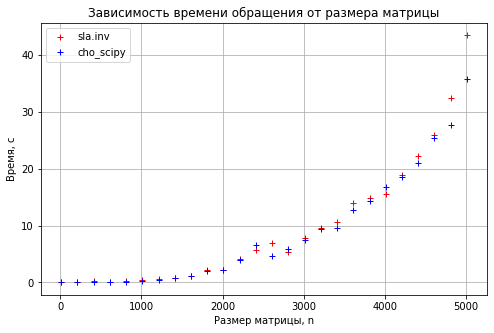

In [29]:
fig = plt.figure(figsize=(8,5))

plt.plot(n_s, t_inv, 'r+', label='sla.inv')
plt.plot(n_s, t_cho, 'b+', label='cho_scipy')

plt.grid()
plt.xlabel('Размер матрицы, n')
plt.ylabel('Время, с')
plt.title('Зависимость времени обращения от размера матрицы')
plt.legend()
plt.show()

А что насчет точности? 

In [18]:
err_inv = []
err_cho = []
n_s = []

for n in range(10, 2100, 200):
    n_s.append(n)
    
    B = np.eye(n)
    A = my_sym_positive(n)
    
    invA = sla.inv(A)
    err_inv.append(sla.norm(invA.dot(A)-B))
    
    c, low = sla.cho_factor(A)
    invA_cho = cho_scipy_solve(A, B, c, low)
    err_cho.append(sla.norm(invA_cho.dot(A)-B))

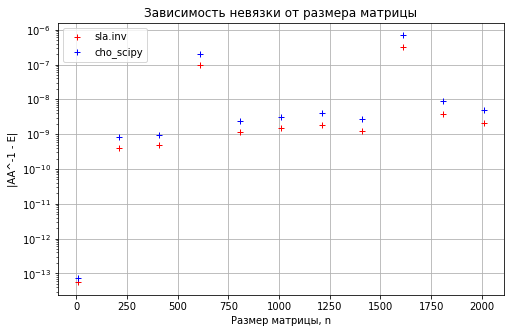

In [21]:
fig = plt.figure(figsize=(8,5))

plt.plot(n_s, err_inv, 'r+', label='sla.inv')
plt.plot(n_s, err_cho, 'b+', label='cho_scipy')

plt.grid()
plt.xlabel('Размер матрицы, n')
plt.ylabel('|AA^-1 - E|')
plt.yscale('log')
plt.title('Зависимость невязки от размера матрицы')
plt.legend()
plt.show()

**Результат:** Библиотечная функция и использование разложения Холецкого дают одинаковые результаты. Предположительно потому, что `inv` так же применяет разложение при обращении матрицы (только LU-разложение в общем случае.) Так как каждый раз обращается новая матрица, возможность использовать вычисленное разложение теряется. 

Однако, применение разложения Холецкого к ковариационной матрице позволяет выиграть у некоторых библиотечных функций для многомерных распределений (но опять же не превосходит обычного обращения). 

Например: вычисление логарифма плотности многомерного нормального распределения с плотностью 

$$p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

Реализую алгоритмы вычисления логарифма с помощью матричного разложения и обращения матрицы и сравню с библиотечной функцией `scipy.stats.multivariate_normal.logpdf`: 

In [10]:
# Разложение

def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    #разложение Холецкого для матрицы ковариации
    c, low = sla.cho_factor(S)
    #L = sla.cholesky(S, lower=True)
    
    d = len(m) #размерность
    const = -0.5*d*np.log(2*np.pi) -0.5*np.log(sla.det(S)) #слагаемое, одинаковое для всех векторов
    
    B = np.eye(d) #правые части для уравнений на обратную матрицу 
    S_inv = cho_scipy_solve(S, B, c, low)
    
    n = len(X)
    res = np.zeros((n,))
    for i in range(n):
        a = X[i] - m
        res[i] = const - 0.5*(a.T.dot(S_inv.dot(a)))

    return res

In [11]:
# Обращение матрицы 

def my_naive_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    
    d = len(m) #размерность
    const = -0.5*d*np.log(2*np.pi) -0.5*np.log(sla.det(S)) #слагаемое, одинаковое для всех векторов
    
    S_inv = sla.inv(S)
    
    n = len(X)
    res = np.zeros((n,))
    for i in range(n):
        a = X[i] - m
        res[i] = const - 0.5*(a.T.dot(S_inv.dot(a)))

    return res

In [12]:
# Библиотечная функция

from scipy.stats import multivariate_normal

In [13]:
d_range = [d for d in range(10, 2100, 100)]
n = 100

times = {'naive':[], 'my':[], 'lib':[]}

for d in d_range:
    
    m = np.zeros(d)
    S =  np.eye(d)
    X_testing = np.random.multivariate_normal(m, S, n)
    
    t0 = time()
    my_naive_multivariate_normal_logpdf(X_testing, m, S)
    t1 = time()
    times['naive'].append(t1-t0)
    
    t0 = time()
    my_multivariate_normal_logpdf(X_testing, m, S)
    t1 = time()
    times['my'].append(t1-t0)
    
    t0 = time()
    multivariate_normal.logpdf(X_testing, m, S)
    t1 = time()
    times['lib'].append(t1-t0)

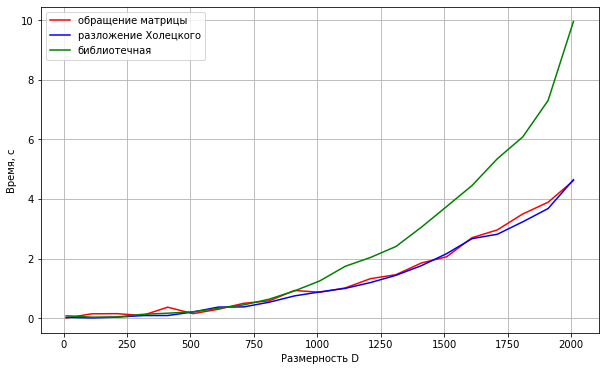

In [14]:
fig = plt.figure(figsize=(10,6))
plt.plot(d_range, times['naive'], 'r', label='обращение матрицы')
plt.plot(d_range, times['my'], 'b', label='разложение Холецкого')
plt.plot(d_range, times['lib'], 'g', label='библиотечная')
plt.grid()
plt.xlabel('Размерность D')
plt.ylabel('Время, с')
plt.legend()
plt.show()

**Вывод:** Не удалось выяснить, что же такое делает библиотечная функция, но разложение и обращение матрицы оказываются значительно быстрее. 

## Примеры задач

Задача определения параметров некоторой функции возникает в самых разных областях. Метод наименьших квадратов позволяет аппроксимировать экспериментальные наблюдения, зная (или поредполагая) только вид зависимости интересующей величины от измеряемых в эксперименте/исследовании величин.  

### Пример 1: Определение параметров резонанса

В эксперименте по $e+e-$ аннигиляции была измерена зависимость сечения рождения $\sigma$ (`s`) некоторого резонанса от энергии $E$. Измерено так же стандартное отклонение сечения $\Delta \sigma$ (`ds`). 

In [24]:
E = [16.0, 18.0, 19.0, 20.0, 20.7, 22.0, 24.0] #Энергии
s = [1.75, 2.42, 3.70, 6.80, 5.28, 2.71, 1.34] #sigma
ds = [0.22, 0.24, 0.33, 0.33, 0.24, 0.17, 0.26] #delta sigma

Полученная зависимость параметризуется функцией 

$$\sigma(E) = \frac{A}{(E - 20)^2 + 1} + B, $$

где $A$ и $B$ - параметры. 

Считая точность измерения энергии много лучше точности измерения сечения, требуется отпределить $A$ и $B$. 

Зависимость: 

In [25]:
def f(E, A, B):
    return A/((E-20)**2 + 1) + B

Вектор параметров $\vec \theta$:

$$\vec \theta =
\begin{pmatrix}
A \\
B \\
\end{pmatrix}
$$

Вектор $\vec Y$:

$$\vec Y =
\begin{pmatrix}
\sigma_0 \\
. \\
. \\
. \\
\sigma_6 \\
\end{pmatrix}
$$

In [26]:
y = np.array(s)
y

array([1.75, 2.42, 3.7 , 6.8 , 5.28, 2.71, 1.34])

Матрица $\hat{G}:$

$$\hat G =
\begin{pmatrix}
\frac{1}{(E_0 - 20)^2 + 1} & 1 \\
. & . \\
. & . \\
. & . \\
\frac{1}{(E_6 - 20)^2 + 1} & 1 \\
\end{pmatrix}
$$

In [29]:
G = np.ones((7,2))
for i in range(len(E)):
    G[i][0] = 1/((E[i] - 20)**2 + 1)
    
G

array([[0.05882353, 1.        ],
       [0.2       , 1.        ],
       [0.5       , 1.        ],
       [1.        , 1.        ],
       [0.67114094, 1.        ],
       [0.2       , 1.        ],
       [0.05882353, 1.        ]])

Ковариационная матрица $D$:

$$ D =
\begin{pmatrix}
\Delta \sigma_0 & 0 & 0 & 0 & 0 & 0 &0  \\
0 & \Delta \sigma_1 & 0 & 0 & 0 & 0 &0  \\
0 & 0 & \Delta \sigma_2 & 0 & 0 & 0 &0  \\
0 & 0 & 0 & \Delta \sigma_3 & 0 & 0 &0  \\
0 & 0 & 0 & 0 & \Delta \sigma_4 & 0 &0  \\
0 & 0 & 0 & 0 & 0 & \Delta \sigma_5 &0  \\
0 & 0 & 0 & 0 & 0 & 0 & \Delta \sigma_6 
\end{pmatrix}
$$

In [30]:
D = np.eye(7)
for i in range(len(ds)):
    D[i][i] = ds[i]
    
D

array([[0.22, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.24, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.26]])

Матрица $\hat B = \hat G^T D^{-1} \hat G$:

In [31]:
B = (G.T.dot(sla.inv(D))).dot(G)
B

array([[ 6.09566862,  9.84530307],
       [ 9.84530307, 28.66790073]])

Нахождение параметров с помощью четырех различных методов: 

In [32]:
b = (G.T.dot(sla.inv(D))).dot(y)

In [34]:
th_naive = naive_solve(B, b)
th_st = standart_solve(B, b)
th_chol = cholesky_solve(B, b)
th_cho = cho_scipy_solve(B, b)

Сравню точность методов: 

In [35]:
err_naive = []
err_st = []
err_chol = []
err_cho = []

for i in range(len(E)):
    err_naive.append(abs(s[i] - f(E[i], A=th_naive[0], B=th_naive[1])))
    err_st.append(abs(s[i] - f(E[i], A=th_st[0], B=th_st[1])))
    err_chol.append(abs(s[i] - f(E[i], A=th_chol[0], B=th_chol[1])))
    err_cho.append(abs(s[i] - f(E[i], A=th_cho[0], B=th_cho[1])))

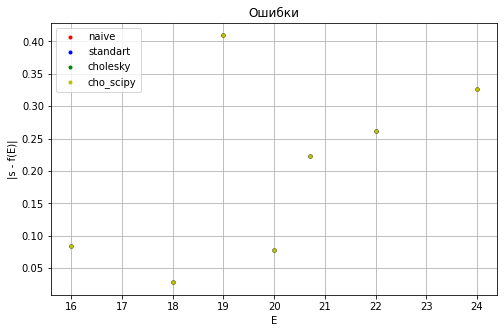

In [39]:
fig = plt.figure(figsize=(8,5))

plt.plot(E, err_naive, 'r.', label='naive')
plt.plot(E, err_st, 'b.', label='standart')
plt.plot(E, err_chol, 'g.', label='cholesky')
plt.plot(E, err_cho, 'y.', label='cho_scipy')
plt.grid()
plt.xlabel('E')
plt.ylabel('|s - f(E)|')
#plt.yscale('log')
plt.title('Ошибки')
plt.legend()
plt.show()

Сравню (средние) скорости вычисления: 

In [42]:
t_naive = 0
t_st = 0
t_chol = 0
t_cho = 0

n = 1000

for i in range(n):
    
    t0_naive = time()
    th_naive = naive_solve(B, b)
    t1_naive = time()
    t_naive += (t1_naive - t0_naive)
    
    t0_st = time()
    th_standart = standart_solve(B, b)
    t1_st = time()
    t_st += (t1_st - t0_st)
    
    t0_chol = time()
    th_chol = cholesky_solve(B, b)
    t1_chol = time()
    t_chol += (t1_chol - t0_chol)
    
    t0_cho = time()
    th_cho = cho_scipy_solve(B, b)
    t1_cho = time()
    t_cho += (t1_cho - t0_cho)
    
t_naive /= n
t_st /= n
t_chol /= n
t_cho /= n

In [43]:
[t_naive, t_st, t_chol, t_cho]

[0.00010036039352416992,
 0.00017577171325683594,
 0.0002496223449707031,
 0.00013369011878967284]

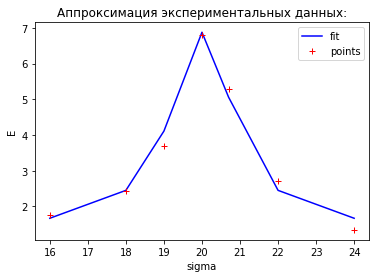

In [44]:
plt.plot(E, [f(e, th_cho[0], th_cho[1]) for e in E], 'b', label='fit')
plt.plot(E, s, 'r+', label='points')

plt.xlabel('sigma')
plt.ylabel('E')
plt.title('Аппроксимация экспериментальных данных:')
plt.legend()

plt.show()

**Результат:**

Для небольших матриц (небольшого количества оцениваемых параметров) все способы дают одинаковый результаты. Простое обращение матрицы `inv` даже дает самое маленькое среднее время вычислений. 

-----

### Пример 2: Линейная регрессия для временных рядов с сезонной составляющей

Данные: 

В таблице представлена статистика коэффициента загрузки гостиниц и средней цены по двум районам Чикаго: Chicago Central Business District Hotel Statistics и Chicago Metropolitan Area Hotel Statistics.

Исследую зависимость от времени коэффициента загрузки гостиниц в процентах (Hotel Occupancy (in %)) для Chicago Central Business District Hotel Statistics.

In [47]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

**Линейная регрессия для временных рядов с сезонной составляющей:**

$$ y_t = (a + c_{base}) + bt + \sum_{i=1}^{12}{(c_i - c_{base})I_i(t)}$$

$c_{base}$ - коэффициент базового месяца, $t$ - номер месяца, $I_i(t)$ - индикаторы месяцев. 


Загрузка и подготовка данных: 

In [48]:
df = pd.read_csv('Chicago_hotels.csv', header=0, sep=';')
df

,date1,date2,x1,x2,x3,x4
0,January,1994,"44,3","104,04","51,9","72,15"
1,February,1994,"54,7","102,74","60,1","73,47"
2,March,1994,"61,9","105,23",65,"74,91"
3,April,1994,"69,1","113,63","69,8","79,06"
4,May,1994,"70,8","120,77","72,4","82,07"
...,...,...,...,...,...,...
115,August,2003,,,,
116,September,2003,,,,
117,October,2003,,,,
118,November,2003,,,,


Убираю ненужные строки и столбцы, решаю проблему с запятыми в числах. 

In [49]:
df_mod = df[:-8]
df_mod = df_mod.drop(columns = ['x2', 'x3', 'x4'])
df_mod['x1'] = [x.replace(',', '.') for x in df_mod['x1']]
df_mod['x1'] = df_mod['x1'].astype(float)

Добавлю столбец - номер месяца и стобцы - индикаторы месяцев. 

In [51]:
df_mod['month_num'] = range(1, len(df_mod) + 1)
df_mod["m01"] = ([1,0,0,0,0,0,0,0,0,0,0,0]*9 + [1,0,0,0])
df_mod["m02"] = ([0,1,0,0,0,0,0,0,0,0,0,0]*9 + [0,1,0,0])
df_mod["m03"] = ([0,0,1,0,0,0,0,0,0,0,0,0]*9 + [0,0,1,0])
df_mod["m04"] = ([0,0,0,1,0,0,0,0,0,0,0,0]*9 + [0,0,0,1])
df_mod["m05"] = ([0,0,0,0,1,0,0,0,0,0,0,0]*9 + [0,0,0,0])
df_mod["m06"] = ([0,0,0,0,0,1,0,0,0,0,0,0]*9 + [0,0,0,0])
df_mod["m07"] = ([0,0,0,0,0,0,1,0,0,0,0,0]*9 + [0,0,0,0])
df_mod["m08"] = ([0,0,0,0,0,0,0,1,0,0,0,0]*9 + [0,0,0,0])
df_mod["m09"] = ([0,0,0,0,0,0,0,0,1,0,0,0]*9 + [0,0,0,0])
df_mod["m10"] = ([0,0,0,0,0,0,0,0,0,1,0,0]*9 + [0,0,0,0])
df_mod["m11"] = ([0,0,0,0,0,0,0,0,0,0,1,0]*9 + [0,0,0,0])
df_mod["m12"] = ([0,0,0,0,0,0,0,0,0,0,0,1]*9 + [0,0,0,0])

Построю график зависимости коэффициента загрузки гостиниц от месяца, чтобы увидеть тип тренда и характер сезонности.

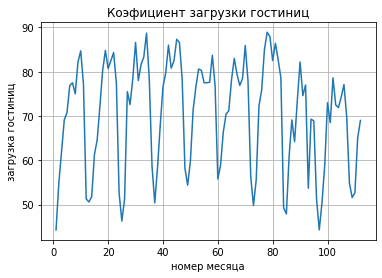

In [52]:
plt.plot(df_mod['month_num'], df_mod['x1'])
plt.grid()
plt.xlabel('номер месяца')
plt.ylabel('загрузка гостиниц')
plt.title('Коэфициент загрузки гостиниц')
plt.show()

Разделю данные на предикторы и отклики для построения модели: 

In [53]:
X_df = df_mod.drop(columns = ['date1', 'date2', 'x1', 'm03'])
y_df = df_mod['x1']

X = np.array(X_df)
y = np.array(y_df)

In [55]:
X.shape

(112, 12)

Дополню матрицу предикторов столбцом единиц, отвечающих за свободный член в модели.

In [56]:
G = np.ones((112, 12+1))
G[:,1:] = X

In [97]:
G

array([[  1.,   1.,   1., ...,   0.,   0.,   0.],
       [  1.,   2.,   0., ...,   0.,   0.,   0.],
       [  1.,   3.,   0., ...,   0.,   0.,   0.],
       ...,
       [  1., 110.,   0., ...,   0.,   0.,   0.],
       [  1., 111.,   0., ...,   0.,   0.,   0.],
       [  1., 112.,   0., ...,   0.,   0.,   0.]])

Снова приходим к СЛАУ (ковариационная матрица единичная): 

$$\hat G^T \hat G \vec \theta = \hat G^T \vec y$$

In [65]:
b = G.T.dot(y)
B = G.T.dot(G)

In [66]:
th_naive = naive_solve(B, b)
th_st = standart_solve(B, b)
th_chol = cholesky_solve(B, b)
th_cho = cho_scipy_solve(B, b)

In [67]:
y_naive = G.dot(th_naive)
y_st = G.dot(th_st)
y_chol = G.dot(th_chol)
y_cho = G.dot(th_cho)

Невязки:

In [70]:
sla.norm(y - y_naive), sla.norm(y - y_st), sla.norm(y - y_chol), sla.norm(y - y_cho) 

(52.14911274294648, 52.14911274294648, 52.14911274294649, 52.149112742946485)

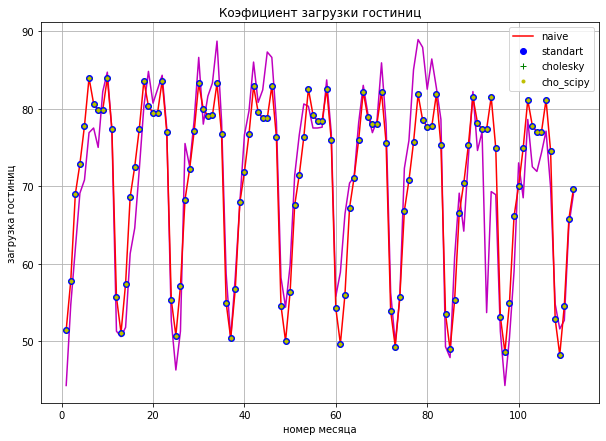

In [78]:
fig = plt.figure(figsize=(10,7))
plt.plot(df_mod['month_num'], df_mod['x1'], 'm')

plt.plot(df_mod['month_num'], y_naive, 'r-', label='naive')
plt.plot(df_mod['month_num'], y_st, 'bo', label='standart')
plt.plot(df_mod['month_num'], y_chol, 'g+', label='cholesky')
plt.plot(df_mod['month_num'], y_cho, 'y.', label='cho_scipy')

plt.grid()
plt.xlabel('номер месяца')
plt.ylabel('загрузка гостиниц')
plt.title('Коэфициент загрузки гостиниц')
plt.legend()
plt.show()

**Результат:**

В плане точности методы снова дают одинаковые результаты, так как размерность небольшая.

Сравню время. 

Принципиальное отличие этой задачи от предыдущей заключается в том, что матрица в левой части СЛАУ не зависит от экспериментальных наблюдений, а зависит только от вида модели (состоит из относительных порядковых номеров месяцев и индикаторов месяцев). Следовательно каждый раз при прогнозировании нового временного ряда будут изменяться лишь отклики $\vec y$, определяющие правую часть. 

Приходим к задаче решения нескольких СЛАУ с одной матрицей, но большим количеством правых частей. 

Проведу эксперимент, в которому буду каждый раз слегка изменять правую часть. Разложения матриц вычислю заранее. 

In [81]:
import random

In [94]:
t_naive = []
t_st = []
t_chol = []
t_cho = []

tn = 0
tst = 0
tchol = 0
tcho = 0

n_s = []

n = 1000


L = sla.cholesky(B, lower=True)
c, low = sla.cho_factor(B)

for i in range(n):
    
    n_s.append(i)
    
    y_new = np.array([yi + 10*random.random() for yi in y])
    b_new = G.T.dot(y_new)
    
    t0_naive = time()
    th_naive = naive_solve(B, b)
    t1_naive = time()
    tn += t1_naive - t0_naive
    t_naive.append(tn)
    
    t0_st = time()
    th_standart = standart_solve(B, b_new)
    t1_st = time()
    tst += t1_st - t0_st
    t_st.append(tst)
    
    t0_chol = time()
    th_chol = cholesky_solve(B, b_new, L)
    t1_chol = time()
    tchol += t1_chol - t0_chol
    t_chol.append(tchol)
    
    t0_cho = time()
    th_cho = cho_scipy_solve(B, b_new, c, low)
    t1_cho = time()
    tcho += t1_cho - t0_cho
    t_cho.append(tcho)

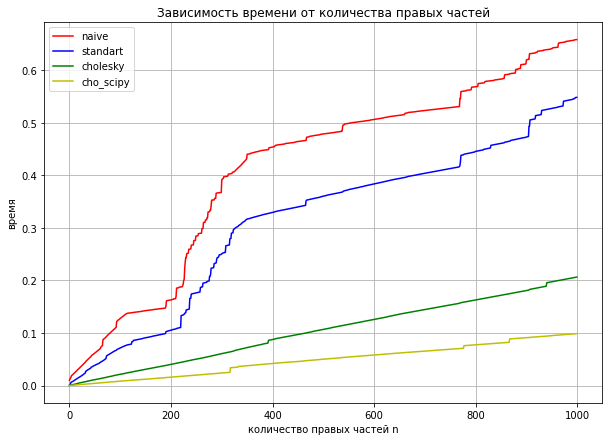

In [95]:
fig = plt.figure(figsize=(10,7))

plt.plot(n_s, t_naive, 'r', label='naive')
plt.plot(n_s, t_st, 'b', label='standart')
plt.plot(n_s, t_chol, 'g', label='cholesky')
plt.plot(n_s, t_cho, 'y', label='cho_scipy')

plt.grid()
plt.xlabel('количество правых частей n')
plt.ylabel('время')
plt.title('Зависимость времени от количества правых частей')
plt.legend()
plt.show()

**Результат:**

Действительно наблюдается значительный выигрыш методов с разложением Холецкого в сравнении со стандартным и с обращением матрицы. 

То есть если нам в конце года надо обработать такой моделью данные про всё-всё-всё (цены домов, спрос на 100 видов хлеба, погоду и настроение 1000 человек), то использование разложения Холецкого с заранее вычесленным разложением значительно ускорит вычисления. 

## Выводы

В работе были исследованы точность и скорость работы четырех методов решения СЛАУ с симметричной положительно определенной матрицей. 

Установлено, что методы с разложением Холецкого дают значительный выигрыш по времени при решении систем с одинаковой матрицей, но большим количеством правых частей. 

Стандартное решение СЛАУ `scipy.linalg.solve` и методы с разложением Холецкого дают более высокую точность для матриц большого размера в сравнении с простым обращением матрицы `inv`. 

Для маленьких матриц в методе наименьших квадратов методы дают одинаковую точность и среднее время вычислений. 

Использование разложения Холецкого для вычисления обратной ковариационной матрицы вместо `inv` не оправдано: оба способа дают одинаковые результаты как по скорости, так и по точности. 

Применение методов с разложением Холецкого к задачам оценки параметров методом наименьших квадратов для небольшого количества параметров и заданных не единичных матриц ковариации не оправдан: разложение Холецкого не несет никаких преимуществ. (Пример 1).

Применение методов с разложением Холецкого оправдано для решения задач с одной матрицей, но изменяющимися правыми частями. (Пример 2).

## Список источников

* Конспекты лекций по линейной алгебре в ШАД Буниной Елены (Лекция 2)

* Презентации к лекциям Епифанова А.Д. к курсу "Статистические методы в ядерном эксперименте"

* Документация к scipy.linalg

* Материалы к курсу "Анализ данных на python" (Линейная регрессия, прогнозирование рядов с сезонной составляющей.)

* Википедия [Разложение Холецкого](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A5%D0%BE%D0%BB%D0%B5%D1%86%D0%BA%D0%BE%D0%B3%D0%BE), [Метод наименьших квадратов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2) 